# Cleaning Knowledge Graphs

Knowledge graphs are a useful way to store relational data from text for LLMs. However, generating these knowledge graphs using LLMs are prone to storing irrelevant information.

In this example, we will use Langchain's LLMGraphTransformer to create a knowledge graph out of sample text about the year 2023, then use degree centrality to find data is irrelevant.

In [20]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

  Using cached https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
import matplotlib.pyplot as plt
import networkx as nx

In [22]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


### Initialize Astra DB / Cassandra

In [23]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(140223276596240) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:da337f5a-b9d1-4c81-b30e-fdbfcbe049ac> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


### Create Graph Store

In [24]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

#Build Knowledge Graph

In [25]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [26]:
text = """
Detailed Summary of 2023
Global Events and Politics:

2023 was a year of profound global political upheavals and events that reshaped the world order. The Russia-Ukraine conflict, which began in 2022, escalated with intense battles in Eastern Ukraine and widespread international sanctions against Russia. The conflict's impact extended beyond the region, causing global energy shortages and inflationary pressures. NATO expanded its presence in Eastern Europe, and several countries increased defense spending in response to the heightened threat perception.

The Middle East experienced significant turmoil, with ongoing civil wars in Syria and Yemen continuing to cause humanitarian crises. Iran's nuclear program negotiations reached a critical juncture, with renewed diplomatic efforts to prevent further proliferation. In Africa, coups and political instability were witnessed in countries like Sudan and Burkina Faso, highlighting the continent's ongoing struggles with governance and security.

Climate change remained a paramount global issue, with 2023 seeing some of the most extreme weather events on record. Devastating floods in South Asia, unprecedented wildfires in Australia and California, and severe heatwaves in Europe underscored the urgent need for comprehensive climate action. The COP28 summit, held in Dubai, saw countries commit to more ambitious targets, though debates over financing for climate adaptation and mitigation persisted.

Technology and Innovation:

Technological innovation surged forward in 2023, particularly in the realm of artificial intelligence (AI). The development of generative AI models like GPT-4 and its successors revolutionized industries from customer service to creative arts. These models exhibited remarkable capabilities in natural language understanding, image generation, and complex problem-solving. AI ethics and regulation became hotly debated topics, with governments and tech companies striving to balance innovation with responsible use.

The tech industry faced economic challenges, with several major companies, including Meta, Amazon, and Google, announcing significant layoffs and restructuring efforts. This was partly due to overexpansion during the pandemic and the need to refocus on profitability and sustainable growth. The semiconductor shortage that began in 2020 continued to affect industries, though increased investment in chip manufacturing provided some relief.

Quantum computing made notable strides, with both public and private sectors investing heavily in research and development. Companies like IBM, Google, and emerging startups demonstrated advancements in quantum processors, bringing us closer to practical quantum computing applications in cryptography, drug discovery, and complex simulations.

Science and Health:

The global health community continued to grapple with the effects of COVID-19. While vaccination rates improved and new antiviral treatments were developed, the emergence of new variants necessitated ongoing vigilance. Long COVID research gained prominence, aiming to understand and mitigate the chronic impacts of the virus on millions of people.

In space exploration, 2023 was a landmark year. NASA's Artemis program made significant progress, with Artemis II successfully orbiting the Moon and laying the groundwork for future manned missions. The James Webb Space Telescope provided unprecedented images and data on distant galaxies, exoplanets, and cosmic phenomena, advancing our understanding of the universe.

Biotechnology and genetic research yielded groundbreaking discoveries. CRISPR technology continued to evolve, enabling more precise genetic modifications and promising treatments for genetic disorders. Personalized medicine, tailored to individuals' genetic profiles, saw increased adoption, particularly in oncology and rare diseases.

Culture and Society:

The cultural landscape of 2023 was vibrant and diverse, reflecting both continuity and change. The entertainment industry rebounded strongly as in-person events, concerts, and film festivals returned to pre-pandemic levels. Streaming services maintained their dominance, producing original content that garnered critical acclaim and massive viewership. The intersection of AI and creativity was particularly noteworthy, with AI-generated music, art, and literature gaining popularity and sparking debates about the future of human creativity.

Social justice movements continued to shape public discourse. The fight for racial equality saw renewed momentum with high-profile protests and legislative efforts in the United States and globally. Gender equality and LGBTQ+ rights also advanced, with several countries enacting progressive policies and legal protections. Environmental activism, especially among younger generations, intensified. Activists pushed for more aggressive climate policies and sustainable practices, emphasizing the urgency of addressing environmental degradation.

Economics and Business:

Global economic conditions in 2023 were marked by volatility and adaptation. Inflationary pressures, driven by energy prices and supply chain disruptions, posed significant challenges for policymakers. Central banks, including the Federal Reserve and the European Central Bank, raised interest rates to combat inflation, leading to mixed economic outcomes.

The cryptocurrency market experienced dramatic fluctuations. Bitcoin and other cryptocurrencies saw periods of rapid appreciation followed by sharp declines, driven by regulatory news, technological advancements, and macroeconomic factors. Regulatory scrutiny increased globally, with governments seeking to establish clearer frameworks to govern digital assets and ensure financial stability.

The labor market underwent substantial changes as remote and hybrid work models became entrenched. This shift affected urban planning, transportation, and commercial real estate, with many companies downsizing office space and investing in digital infrastructure. The "Great Resignation" trend persisted, with workers seeking better work-life balance, higher wages, and more fulfilling careers.

Overall, 2023 was a year marked by significant challenges and remarkable advancements across various domains. It reflected the complexity and dynamism of the modern world, highlighting humanity's resilience and capacity for innovation in the face of adversity.
"""

In [27]:
from langchain_core.documents import Document
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='2023', type='Year'), Node(id='Russia-Ukraine Conflict', type='Event'), Node(id='Russia', type='Country'), Node(id='Ukraine', type='Country'), Node(id='Nato', type='Organization'), Node(id='Eastern Europe', type='Region'), Node(id='Middle East', type='Region'), Node(id='Syria', type='Country'), Node(id='Yemen', type='Country'), Node(id='Iran', type='Country'), Node(id='Africa', type='Continent'), Node(id='Sudan', type='Country'), Node(id='Burkina Faso', type='Country'), Node(id='Climate Change', type='Issue'), Node(id='Cop28 Summit', type='Event'), Node(id='Dubai', type='City'), Node(id='Artificial Intelligence', type='Technology'), Node(id='Gpt-4', type='Ai model'), Node(id='Meta', type='Company'), Node(id='Amazon', type='Company'), Node(id='Google', type='Company'), Node(id='Quantum Computing', type='Technology'), Node(id='Ibm', type='Company'), Node(id='Covid-19', type='Disease'), Node(id='Nasa', type='Organization'), Node(id='Artemis Ii', type='Space mission'), Node(

In [28]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

In [29]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

# Test Knowledge Graph Query

### Testing for hallucination

In [30]:
chain.invoke("Who is Alice")

AIMessage(content="The information provided does not include any knowledge graph triples. Therefore, it's not possible to provide information about who Alice is.", response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 57, 'total_tokens': 82}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-9d6f65c8-9d79-49a7-b843-58ecd096992c-0')

### Testing for output quality

In [31]:
chain.invoke("What happened in 2023?")

AIMessage(content="In 2023, there were advancements in quantum computing, artificial intelligence, James Webb Space Telescope, CRISPR technology, and personalized medicine. The social justice movements advocating for gender equality, LGBTQ+ rights, and racial equality saw renewed momentum. The year also included the Cop28 Summit held in Dubai and the expansion of NATO's presence in Eastern Europe. Environmental activism intensified, and the entertainment industry, particularly AI-generated music, art, and literature, gained popularity.\n\nThe Federal Reserve and the European Central Bank raised interest rates due to inflation. NASA launched the Artemis II mission, and the Artemis Program also advanced. The Great Resignation persisted, and remote work became more entrenched. Bitcoin experienced fluctuations, and the cryptocurrency market was affected.\n\nIn the corporate world, companies like Amazon, Google, and Meta announced layoffs and restructuring. Geopolitically, the year was mark

#Visualize Graph

In [32]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: 2023, Type: Year
ID: Russia-Ukraine Conflict, Type: Event
ID: Russia, Type: Country
ID: Ukraine, Type: Country
ID: Nato, Type: Organization
ID: Eastern Europe, Type: Region
ID: Middle East, Type: Region
ID: Syria, Type: Country
ID: Yemen, Type: Country
ID: Iran, Type: Country
ID: Africa, Type: Continent
ID: Sudan, Type: Country
ID: Burkina Faso, Type: Country
ID: Climate Change, Type: Issue
ID: Cop28 Summit, Type: Event
ID: Dubai, Type: City
ID: Artificial Intelligence, Type: Technology
ID: Gpt-4, Type: Ai model
ID: Meta, Type: Company
ID: Amazon, Type: Company
ID: Google, Type: Company
ID: Quantum Computing, Type: Technology
ID: Ibm, Type: Company
ID: Covid-19, Type: Disease
ID: Nasa, Type: Organization
ID: Artemis Ii, Type: Space mission
ID: James Webb Space Telescope, Type: Telescope
ID: Crispr Technology, Type: Technology
ID: Personalized Medicine, Type: Medical approach
ID: Entertainment Industry, Type: Industry
ID: Ai-Generated Music, Type: Art form
ID: Social Justice 

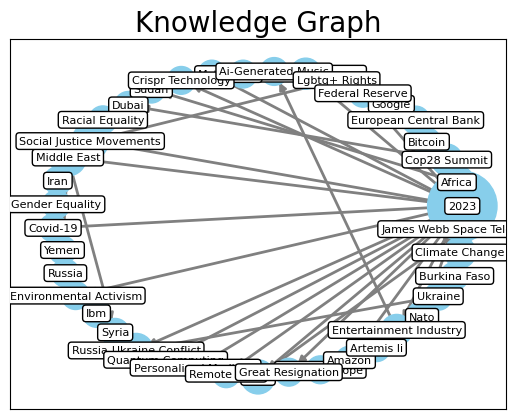

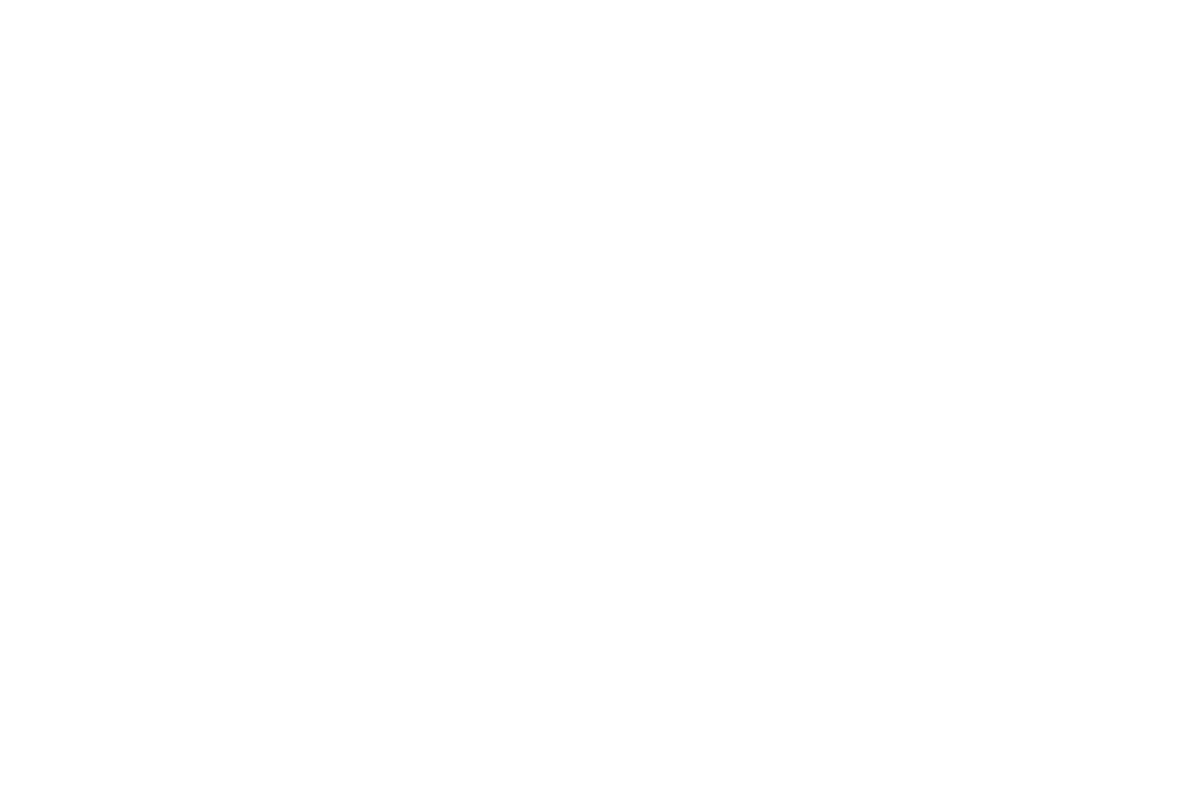

In [33]:
def create_networkx_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    return G
def visualize_networkx_graph(G):
    # Identify all nodes that are sources of relationships
    source_nodes = set(G.predecessors(node) for node in G.nodes)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=20, iterations=200, center=(0.5, 0.5))  # Increase k value for more spacing

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [300 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    plt.title("Knowledge Graph", fontsize=20)
    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.axis('off')  # Hide axis
    plt.show()

G = create_networkx_graph(graph_documents)
visualize_networkx_graph(G)

# Remove Outlier Clusters

To determine which nodes should be removed, we calculate the degree centrality of each node and find the nodes with the least centrality.

For a node $v$ in a graph $G$, the degree centrality is defined as:

$$
C_D(v) = \frac{\text{degree}(v)}{N - 1}
$$

where:
- $\text{degree}(v)$ is the number of edges connected to node \( v \).
- $N$ is the total number of nodes in the graph.

In this example, nodes "Russia" and "Ukraine" are removed, which makes sense because the information they provide is already represented with node "Russia-Ukraine Conflict."

In [34]:
# Custom degree centrality calculation
def calculate_degree_centrality(G):
    centrality = {}
    num_nodes = len(G.nodes())
    for node in G.nodes():
        degree = G.degree(node)
        centrality[node] = degree / (num_nodes - 1)
    return centrality

# Calculate degree centrality
centrality = calculate_degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda item: item[1])

# Print nodes from least to most central
for node, cent in sorted_centrality:
    print(f'Node {node}: Centrality = {cent:.4f}')

Node Russia: Centrality = 0.0250
Node Ukraine: Centrality = 0.0250
Node Eastern Europe: Centrality = 0.0250
Node Syria: Centrality = 0.0250
Node Yemen: Centrality = 0.0250
Node Iran: Centrality = 0.0250
Node Sudan: Centrality = 0.0250
Node Burkina Faso: Centrality = 0.0250
Node Dubai: Centrality = 0.0250
Node Gpt-4: Centrality = 0.0250
Node Meta: Centrality = 0.0250
Node Amazon: Centrality = 0.0250
Node Google: Centrality = 0.0250
Node Ibm: Centrality = 0.0250
Node Covid-19: Centrality = 0.0250
Node Artemis Ii: Centrality = 0.0250
Node James Webb Space Telescope: Centrality = 0.0250
Node Crispr Technology: Centrality = 0.0250
Node Personalized Medicine: Centrality = 0.0250
Node Ai-Generated Music: Centrality = 0.0250
Node Racial Equality: Centrality = 0.0250
Node Gender Equality: Centrality = 0.0250
Node Lgbtq+ Rights: Centrality = 0.0250
Node Environmental Activism: Centrality = 0.0250
Node Federal Reserve: Centrality = 0.0250
Node European Central Bank: Centrality = 0.0250
Node Bitco

### Remove K Nodes

In [35]:
def remove_node_by_id(doc, node_id):
    # Remove the node
    doc.nodes = [node for node in doc.nodes if node.id != node_id]
    # Remove any relationships involving the node
    doc.relationships = [rel for rel in doc.relationships if rel.source.id != node_id and rel.target.id != node_id]

# k is the number of nodes you want to remove
k = 2

nodes_to_remove = [node for node, _ in sorted_centrality[:k]]

for node_id in nodes_to_remove:
    for doc in graph_documents:
        remove_node_by_id(doc, node_id)

In [36]:
for doc in graph_documents:
    # Print the remaining nodes and relationships
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")

    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source.id}, Target: {relationship.target.id}, Type: {relationship.type}")

Nodes:
ID: 2023, Type: Year
ID: Russia-Ukraine Conflict, Type: Event
ID: Nato, Type: Organization
ID: Eastern Europe, Type: Region
ID: Middle East, Type: Region
ID: Syria, Type: Country
ID: Yemen, Type: Country
ID: Iran, Type: Country
ID: Africa, Type: Continent
ID: Sudan, Type: Country
ID: Burkina Faso, Type: Country
ID: Climate Change, Type: Issue
ID: Cop28 Summit, Type: Event
ID: Dubai, Type: City
ID: Artificial Intelligence, Type: Technology
ID: Gpt-4, Type: Ai model
ID: Meta, Type: Company
ID: Amazon, Type: Company
ID: Google, Type: Company
ID: Quantum Computing, Type: Technology
ID: Ibm, Type: Company
ID: Covid-19, Type: Disease
ID: Nasa, Type: Organization
ID: Artemis Ii, Type: Space mission
ID: James Webb Space Telescope, Type: Telescope
ID: Crispr Technology, Type: Technology
ID: Personalized Medicine, Type: Medical approach
ID: Entertainment Industry, Type: Industry
ID: Ai-Generated Music, Type: Art form
ID: Social Justice Movements, Type: Movement
ID: Racial Equality, Type: 

### The removed nodes dont affect the LLM output, meaning that they were unnecessary

In [37]:
chain.invoke("What happened in 2023?")

AIMessage(content="In 2023, advancements were made in Quantum Computing and Artificial Intelligence, including the development of GPT-4. There were also advancements in the James Webb Space Telescope and CRISPR technology. The year saw an increase in adoption of personalized medicine. In the field of social justice, movements for gender equality, racial equality, and LGBTQ+ rights were advocated and addressed. \n\nThe Middle East, including Syria and Yemen, experienced civil wars. Africa also experienced instability, with political instability particularly noted in Sudan and Burkina Faso. The Russia-Ukraine conflict was also a significant event. \n\nThe COP28 Summit was held in Dubai, addressing the issue of climate change. Environmental activism also intensified. Nato expanded its presence in Eastern Europe. \n\nIn the economic sphere, the Federal Reserve and the European Central Bank raised interest rates as the economy experienced inflation. Both Amazon and Google announced layoffs 